In [1]:
#%pip install scikit-posthocs

In [2]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import scikit_posthocs as posthocs

import sqlite3 as sql

import matplotlib.pyplot as plt
import seaborn as sns

Анализ продаж на маркетплейсе с целью оценки и поиска точек роста:  
1. Оценить динамику среднего чека и прироста продаж
1. Изучить долю по способам оплаты
1. Оценить продажи по штатам
1. Оценить продажи по категориям товаров


При отборе заказов за последний год будет использоваться дата оформления покупки, рассмотрим записи с предпоследний месяц, по этот же месяц в прошлом году

### Подключение к БД

In [3]:
con = sql.connect("olist.sqlite")
cur = con.cursor()

In [4]:
pd.read_sql("""SELECT MAX(order_purchase_timestamp) FROM orders""", con)

,MAX(order_purchase_timestamp)
0,2018-10-17 17:30:18


In [5]:
pd.read_sql('SELECT DISTINCT order_status FROM orders', con)

,order_status
0,delivered
1,invoiced
2,shipped
3,processing
4,unavailable
5,canceled
6,created
7,approved


По ходу работы будут нужны данные из таблиц order_items, orders, customres и order_payments

## 1. Динамика прироста продаж и среднего чека

In [6]:
df = pd.read_sql("""
       WITH CTE AS (
       SELECT oi.order_id,
            SUM(oi.price) as order_price
       FROM order_items oi
       JOIN orders o ON oi.order_id = o.order_id
       WHERE (o.order_purchase_timestamp BETWEEN '2017-09-01 00:00:00' AND '2018-09-31 23:59:59')
            AND (o.order_status = 'delivered')
       GROUP BY oi.order_id
            )
              SELECT CTE.order_id,
                    c.customer_unique_id,
                    c.customer_state as state,
                    CTE.order_price,
                    o.order_purchase_timestamp as purchase_date,
                    o.order_delivered_customer_date as delivered,
                    o.order_estimated_delivery_date as estimated
              FROM CTE 
              JOIN orders o ON CTE.order_id = o.order_id
              JOIN customers c ON o.customer_id = c.customer_id
""", con)
df.shape

(74213, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74213 entries, 0 to 74212
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            74213 non-null  object 
 1   customer_unique_id  74213 non-null  object 
 2   state               74213 non-null  object 
 3   order_price         74213 non-null  float64
 4   purchase_date       74213 non-null  object 
 5   delivered           74206 non-null  object 
 6   estimated           74213 non-null  object 
dtypes: float64(1), object(6)
memory usage: 4.0+ MB


В колоке delivered (order_delivered_customer_date) есть пропуски. Это странно, поскольку в таблицу были отобраны заказы, имеющие статус "доставлен". Следует исключить эти заказы из наблюдения и записать id заказов

In [8]:
sus_orders = df[df['delivered'].isna()].order_id
sus_orders.shape

(7,)

In [9]:
df.dropna(inplace=True)

In [10]:
df['purchase_date'] = df['purchase_date'].astype('datetime64[ns]')
df['delivered'] = df['delivered'].astype('datetime64[ns]')
df['estimated'] = df['estimated'].astype('datetime64[ns]')

df['state'] = df['state'].astype('category')

df['month'] = df['purchase_date'].dt.strftime('%Y-%m')

In [11]:
df.describe()

,order_price,purchase_date,delivered,estimated
count,74206.000000,74206,74206,74206
mean,137.273277,2018-03-09 10:10:54.068498688,2018-03-22 01:37:44.063471872,2018-04-01 13:23:45.232461056
min,0.850000,2017-09-01 00:03:50,2017-09-04 18:53:59,2017-09-14 00:00:00
25%,46.200000,2017-12-12 10:32:04.249999872,2017-12-28 22:07:47.750000128,2018-01-09 00:00:00
50%,87.500000,2018-03-09 14:26:39.500000,2018-03-27 15:55:24.500000,2018-04-02 00:00:00
75%,149.900000,2018-06-01 12:15:26.249999872,2018-06-12 17:08:02.750000128,2018-06-29 00:00:00
max,13440.000000,2018-08-29 15:00:37,2018-10-17 13:22:46,2018-10-25 00:00:00
std,206.741261,NaN,NaN,NaN


In [12]:
sold = df.groupby('month').agg(
    total_orders = ('order_id','count'),
    income = ('order_price','sum')
)
sold['AOV'] = sold['income']/sold['total_orders']
sold['income_growth'] = sold['income'].pct_change()

In [13]:
sold

,total_orders,income,AOV,income_growth
month,,,,
2017-09,4150,607399.67,146.361366,NaN
2017-10,4478,648247.65,144.762762,0.067251
2017-11,7288,987648.07,135.517024,0.523566
2017-12,5513,726033.19,131.694756,-0.264887
2018-01,7069,924645.00,130.802801,0.273557
2018-02,6555,826437.13,126.077365,-0.106211
2018-03,7003,953356.25,136.135406,0.153574
2018-04,6798,973534.09,143.208898,0.021165
2018-05,6749,977544.69,144.842894,0.004120


In [14]:
sold.fillna(value=0, inplace=True)
multipal_order_customers_filter = df[df.customer_unique_id.duplicated()].customer_unique_id.unique()
df_active_custs = df[df['customer_unique_id'].isin(multipal_order_customers_filter)]
df_active_custs.shape

(3760, 8)

In [15]:
arppu = df_active_custs.groupby('month').agg(
    repeated_orders = ('order_id','count'),
    r_income = ('order_price','sum')
)
arppu['arppu'] = arppu['r_income']/arppu['repeated_orders']

In [16]:
sold = sold.join(arppu, how='left').reset_index()

Text(0.5, 1.0, 'Выручка')

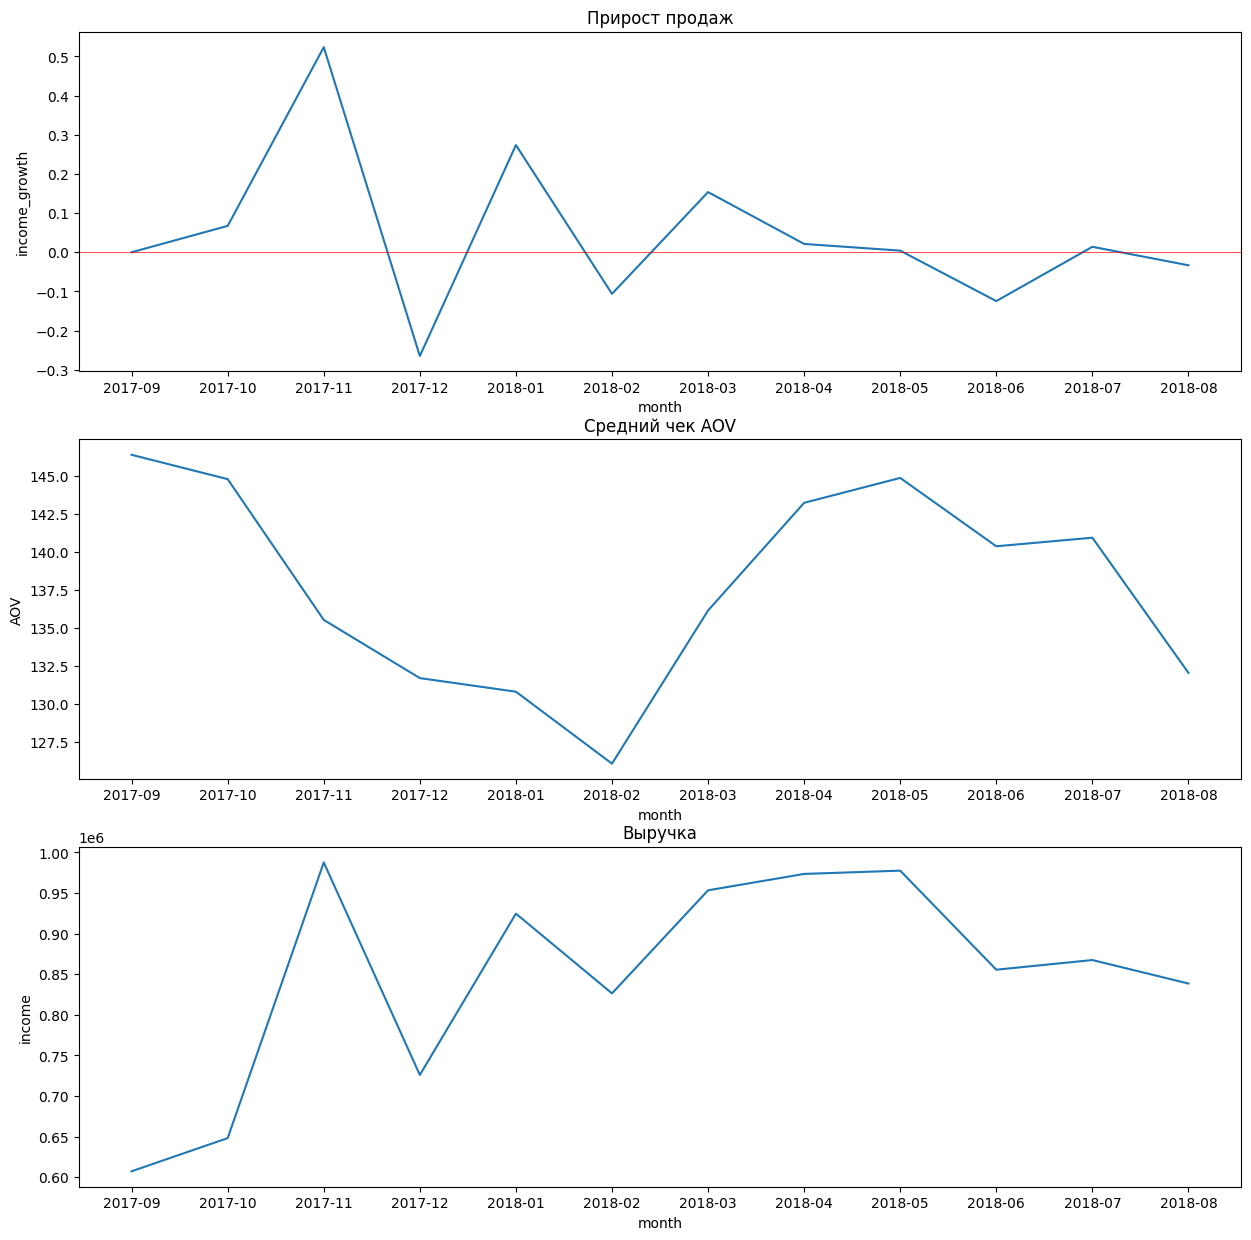

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))
sns.lineplot(data=sold,
             x='month',
             y='income_growth',
             ax=axs[0])
axs[0].axhline(y=0, color='red', linewidth=0.5)
axs[0].set_title('Прирост продаж')
sns.lineplot(data=sold,
             x='month',
             y='AOV',
             ax=axs[1])
axs[1].set_title('Средний чек AOV')
sns.lineplot(data=sold,
             x='month',
             y='income',
             ax=axs[2])
axs[2].set_title('Выручка')

In [18]:
display(sold[sold['month'].isin(['2017-09','2017-11','2018-08'])])
print('Разница начало и конец года:', (sold.income.tail(1).values-sold.income.head(1).values),
      (sold.income.tail(1).values-sold.income.head(1).values)/sold.income.head(1).values*100)

,month,total_orders,income,AOV,income_growth,repeated_orders,r_income,arppu
0,2017-09,4150,607399.67,146.361366,0.000000,261,31825.80,121.937931
2,2017-11,7288,987648.07,135.517024,0.523566,397,50142.15,126.302645
11,2018-08,6351,838576.64,132.038520,-0.033326,214,27156.51,126.899579


Разница начало и конец года: [231176.97] [38.06010794]


Можно наблюдать следующее: скачки темпов прироста продаж c ноября по февраль с последующей относительной стабилизацией. В ноябре 2017 продажи выросли на 52% в сравнении с предыдущим месяцем (скорее всего результат ноябрьских скидок). К концу периода выручка увеличилась на 231177 реалов в сравнении с началом (38%)

## 2. Изучить долю по способам оплаты

In [19]:
pay_types_df = pd.read_sql("""
    SELECT op.payment_type,
           sum(op.payment_value) as payment_total,
           count(op.order_id) as order_count
    FROM order_payments op
    JOIN orders o ON op.order_id = o.order_id
    WHERE (o.order_purchase_timestamp BETWEEN '2017-09-01 00:00:00' AND '2018-09-31 23:59:59')
            AND (o.order_status = 'delivered') AND (o.order_delivered_customer_date IS NOT NULL)
    GROUP BY op.payment_type
    ORDER BY payment_total DESC
""", con)
display(pay_types_df)

,payment_type,payment_total,order_count
0,credit_card,9389670.53,57625
1,boleto,2069092.20,14400
2,voucher,252952.84,3809
3,debit_card,189112.19,1298


In [20]:
pay_types_df['payment_share'] = (pay_types_df['payment_total']/pay_types_df['payment_total'].sum() * 100).round(decimals=2)
pay_types_df['transaction_share'] = (pay_types_df['order_count']/pay_types_df['order_count'].sum() * 100).round(decimals=2)

In [21]:
pay_types_df

,payment_type,payment_total,order_count,payment_share,transaction_share
0,credit_card,9389670.53,57625,78.90,74.71
1,boleto,2069092.20,14400,17.39,18.67
2,voucher,252952.84,3809,2.13,4.94
3,debit_card,189112.19,1298,1.59,1.68


<Axes: xlabel='payment_type', ylabel='transaction_share'>

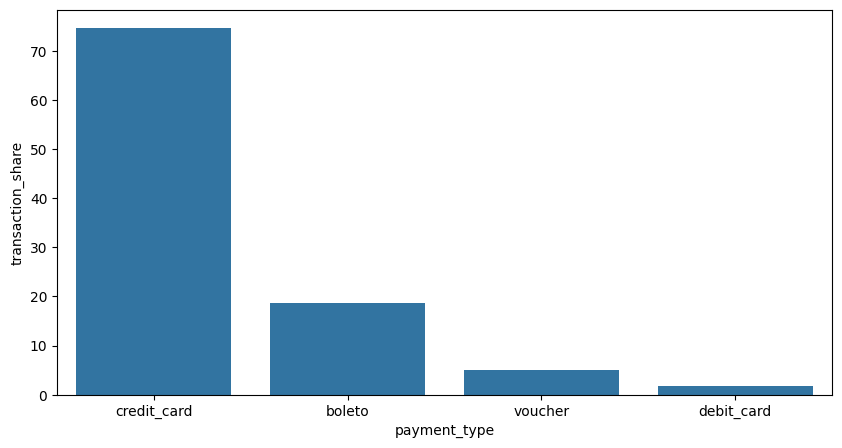

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(data=pay_types_df, x='payment_type', y='transaction_share')

In [23]:
pay_types_df = pd.read_sql("""
    SELECT strftime('%Y-%m', o.order_purchase_timestamp) as month,
                           op.payment_type, 
                           count(op.order_id) as transactions,
                           sum(op.payment_value) as payment_value
    FROM order_payments op
    JOIN orders o ON op.order_id = o.order_id
    WHERE (o.order_purchase_timestamp BETWEEN '2017-09-01 00:00:00' AND '2018-09-31 23:59:59')
            AND (o.order_status = 'delivered') AND (o.order_delivered_customer_date IS NOT NULL)
    GROUP BY op.payment_type, strftime('%Y-%m', o.order_purchase_timestamp)
    ORDER BY month, payment_value DESC
""", con)

In [24]:
pay_types_df['ATV'] = pay_types_df['payment_value']/pay_types_df['transactions'] #средняя стоимость транзакции

In [25]:
total = pay_types_df.groupby(by='month').agg(
    total_transactions = ('transactions','sum')
)
pay_types_df = pay_types_df.join(total, on='month', how='left')
pay_types_df['transactions_share'] = (pay_types_df['transactions']/pay_types_df['total_transactions'] * 100).round(decimals=2)

In [26]:
pay_types_df.sample(20).sort_values(by='payment_type')

,month,payment_type,transactions,payment_value,ATV,total_transactions,transactions_share
1,2017-09,boleto,868,126486.97,145.722316,4371,19.86
5,2017-10,boleto,955,134803.57,141.155571,4698,20.33
25,2018-03,boleto,1316,186542.63,141.749719,7297,18.03
13,2017-12,boleto,1134,160757.89,141.761808,5729,19.79
21,2018-02,boleto,1294,178793.80,138.171406,6776,19.10
29,2018-04,boleto,1265,190568.30,150.646877,7067,17.90
12,2017-12,credit_card,4245,654398.92,154.157578,5729,74.10
20,2018-02,credit_card,5114,758559.66,148.330008,6776,75.47
4,2017-10,credit_card,3416,592408.10,173.421575,4698,72.71
28,2018-04,credit_card,5341,910311.49,170.438399,7067,75.58


<Axes: xlabel='month', ylabel='transactions_share'>

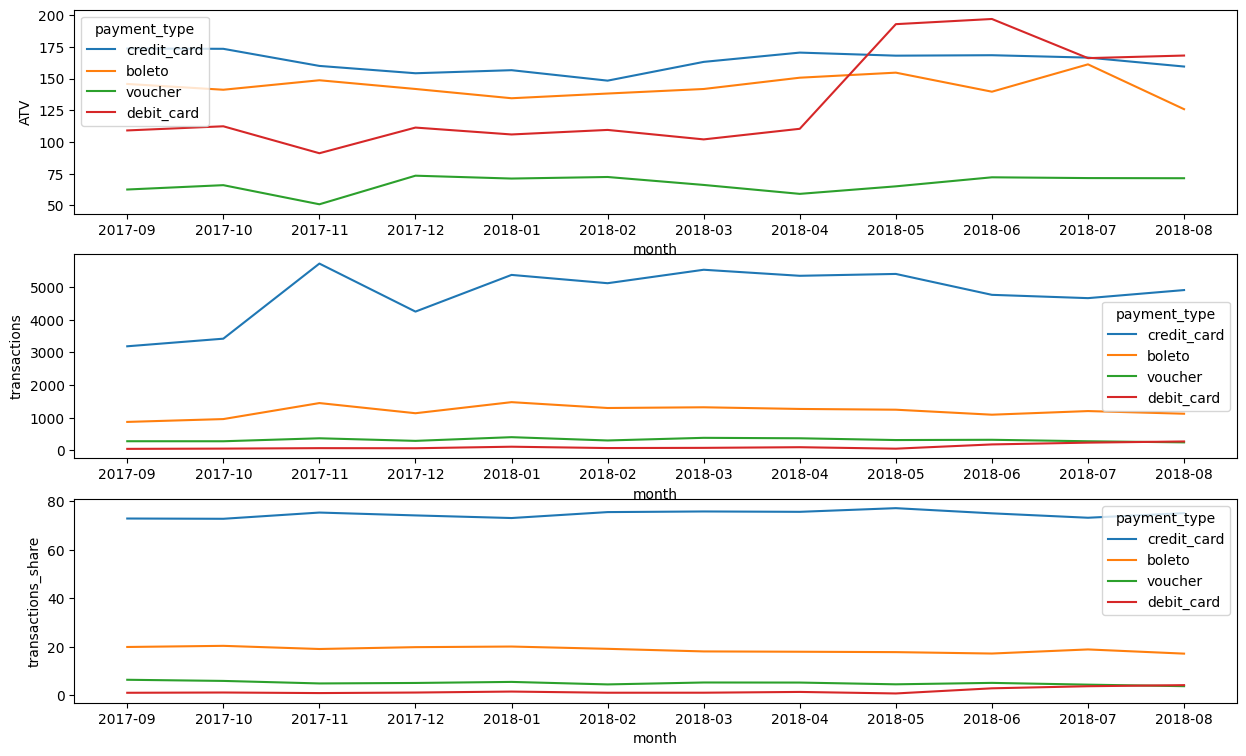

In [27]:
fig, axs = plt.subplots(3,1, figsize=(15,9))
sns.lineplot(data=pay_types_df,
             x='month',
             y='ATV',
             hue='payment_type',
             ax=axs[0])
sns.lineplot(data=pay_types_df,
             x='month',
             y='transactions',
             hue='payment_type',
             ax=axs[1])
sns.lineplot(data=pay_types_df,
             x='month',
             y='transactions_share',
             hue='payment_type',
             ax=axs[2])

In [28]:
pay_types_df[pay_types_df['payment_type']=='debit_card'].sort_values(by='month').tail(6)

,month,payment_type,transactions,payment_value,ATV,total_transactions,transactions_share
27,2018-03,debit_card,74,7549.05,102.014189,7297,1.01
31,2018-04,debit_card,94,10375.06,110.372979,7067,1.33
35,2018-05,debit_card,49,9449.86,192.854286,7002,0.70
38,2018-06,debit_card,179,35251.20,196.934078,6347,2.82
42,2018-07,debit_card,234,38863.17,166.081923,6367,3.68
46,2018-08,debit_card,270,45390.52,168.113037,6535,4.13


Кредитная карта - доминирующий способ оплаты на маркетплейсе  

Топ 2 - болето. Болето - способ оплаты в бразилии, который представляет собой подобие ваучера или банковского чека со штрихкодом для проведения оплаты.

На графиках выше видно, что с 2018-04 средний чек для дебетовой карты заметно вырос. Это говорит о возможном изменении финансового поведения и/или покупательной способности.
Также же заметен и рост доли дебетовой карты на фоне колебаний болето. Такая тенденция при сохранении может являтся благоприятной для разработки и представления своего банковского продукта - кредитной или банковской карты со стимуляцией перехода на него вместо болето или других карт и предоставлением скидок. В перспективе такое решение простимулирует продажи

Соглаcно новостям, по состоянию на 2024 год olist уже планирует обрабатывать до 15% транзакций самостоятельно, т.е. оказывает банковские услуги и имеет свои платежные продукты

Выдвинем гипотезу об отсутсвии различий стоимости транзакций для разных методов оплаты

### Разница стоимости транзакций по типам оплаты

In [29]:
transactions_2017 = pd.read_sql("""
                           SELECT op.payment_type, 
                                  op.payment_value
                           FROM order_payments op
                           JOIN orders o ON op.order_id = o.order_id
                           WHERE (o.order_purchase_timestamp BETWEEN '2017-09-01 00:00:00' AND '2018-09-31 23:59:59')
            AND (o.order_status = 'delivered') AND (o.order_delivered_customer_date IS NOT NULL)
                           """, con)
transactions_2017.describe()

,payment_value
count,77132.000000
mean,154.291705
std,213.002550
min,0.000000
25%,57.680000
50%,101.250000
75%,173.135000
max,13664.080000


<Axes: >

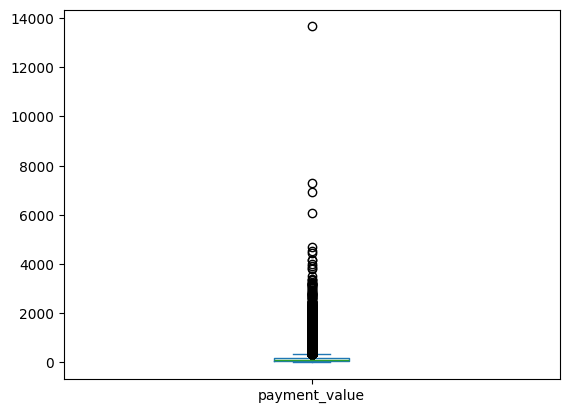

In [30]:
transactions_2017.payment_value.plot(kind='box')

In [31]:
transactions_2017.groupby('payment_type').agg(['count', 'mean', 'median', 'std'])

payment_value                                
                     count        mean  median         std
payment_type                                              
boleto               14400  143.686958   94.77  207.519967
credit_card          57625  162.944391  107.78  217.650835
debit_card            1298  145.695062   92.57  248.703449
voucher               3809   66.409252   42.77   94.386313

In [32]:
credit = transactions_2017[transactions_2017['payment_type']=='credit_card']['payment_value']
boleto = transactions_2017[transactions_2017['payment_type']=='boleto']['payment_value']
debit = transactions_2017[transactions_2017['payment_type']=='debit_card']['payment_value']
voucher = transactions_2017[transactions_2017['payment_type']=='voucher']['payment_value']

In [33]:
stat, pval = stats.kruskal(credit,boleto,debit,voucher)
print(f'Н критерий: {stat}, pval: {pval}')
n = len(transactions_2017)
k = 4
print(f'Размер эффекта: {(stat - k + 1)/(n-k)}')

Н критерий: 3454.986386691478, pval: 0.0
Размер эффекта: 0.04475659146732027


Нулевая гипотеза о равенстве медианных значений стоимости оплаты для разных способов оплаты отвергается: способ платежа и стоимость транзакции связаны. Эффект выражен слабо

In [34]:
dunn = posthocs.posthoc_dunn(a=transactions_2017,
                             val_col='payment_value',
                             group_col='payment_type',
                             p_adjust='holm',
                             sort=True
                             )
dunn

,boleto,credit_card,debit_card,voucher
boleto,1.000000e+00,1.314546e-48,1.409518e-01,0.000000e+00
credit_card,1.314546e-48,1.000000e+00,2.943194e-10,0.000000e+00
debit_card,1.409518e-01,2.943194e-10,1.000000e+00,2.412330e-133
voucher,0.000000e+00,0.000000e+00,2.412330e-133,1.000000e+00


<Axes: >

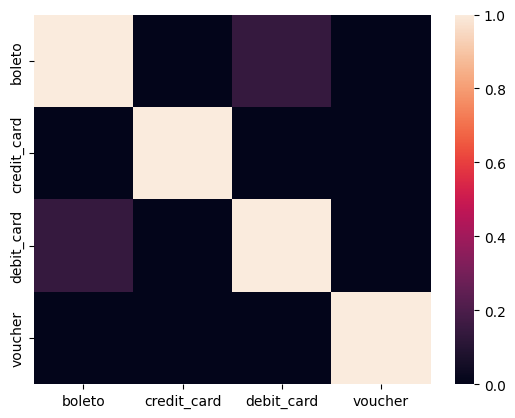

In [35]:
sns.heatmap(dunn)

Существуют различия в размерах платежей между кредитной, дебетовой картой, болето и ваучером. При этом для пары болето-дебетовая карта статистически значимых различий не выявлено. Это закономерно, суть дебетовой карты и болето схожа - использование собственных, а не заемных средств, как в случае с кредитной картой

Медиана:
 * для кредитной карты = 107.78 реалов
 * для болето = 94.77 реалов
 * для дебетовой карты = 92.57 реала
 * для ваучера = 42.77 реала

## 3. Анализ продаж по штатам

In [36]:
print(df.state.nunique()) # количество states

27


В бразилии 26 штатов и 1 федеральный округ. Olist действует в каждом федеральном субъекте

In [37]:
df.state.value_counts(normalize=True)*100

state
SP    42.881977
RJ    12.593321
MG    11.730857
RS     5.310891
PR     4.999596
SC     3.626391
BA     3.344743
DF     2.243754
ES     2.042961
GO     2.022747
PE     1.656200
CE     1.282915
MT     0.919063
PA     0.906935
MS     0.746570
MA     0.711533
PB     0.520174
RN     0.482441
PI     0.481093
AL     0.381371
SE     0.309948
TO     0.274910
RO     0.223702
AM     0.134760
AP     0.070075
AC     0.063337
RR     0.037733
Name: proportion, dtype: float64

Почти половина заказов olist приходится на Сан Паулу - это экономический и финансовый центр бразилии.
Около 65% заказов olist'a сделано в трех крупнейших федеральных образованиях.  
  
  Далее доля резко падает, что закономерно из-за меньшей численности населения в этих штатах. Так, население Рио-Гранди-ду-Сул(RS), Парана(PR) как раз примерно в два раза меньше неселения Рио-де-Жанейро(RJ) и Минас-Жейрас(MG)

  Проведем анализ продаж для топ 3 штатов

In [38]:
mask = ((df['state'] == 'SP')|(df['state'] == 'RJ')|(df['state'] == 'MG'))

states = df[mask].groupby(['state','month'], observed=True).agg(
    total_orders = ('order_id','count'),
    income = ('order_price','sum')
)
states['AOV'] = states['income']/states['total_orders']

s_arppu = df_active_custs[((df_active_custs['state'] == 'SP')
                           |(df_active_custs['state'] == 'RJ')
                           |(df_active_custs['state'] == 'MG'))].groupby(
                               ['state','month'], observed=True
                               ).agg(
    repeated_orders = ('order_id','count'),
    r_income = ('order_price','sum')
)
s_arppu['arppu'] = s_arppu['r_income']/s_arppu['repeated_orders']

states = states.join(s_arppu, on=['state','month'], how='left').reset_index()

states['state'] = states['state'].astype('object') #categorical некорректно выводит легенду на графиках
states['income_growth'] = states['income'].pct_change()
states.loc[states['month']=='2017-09', ['income_growth']] = 0

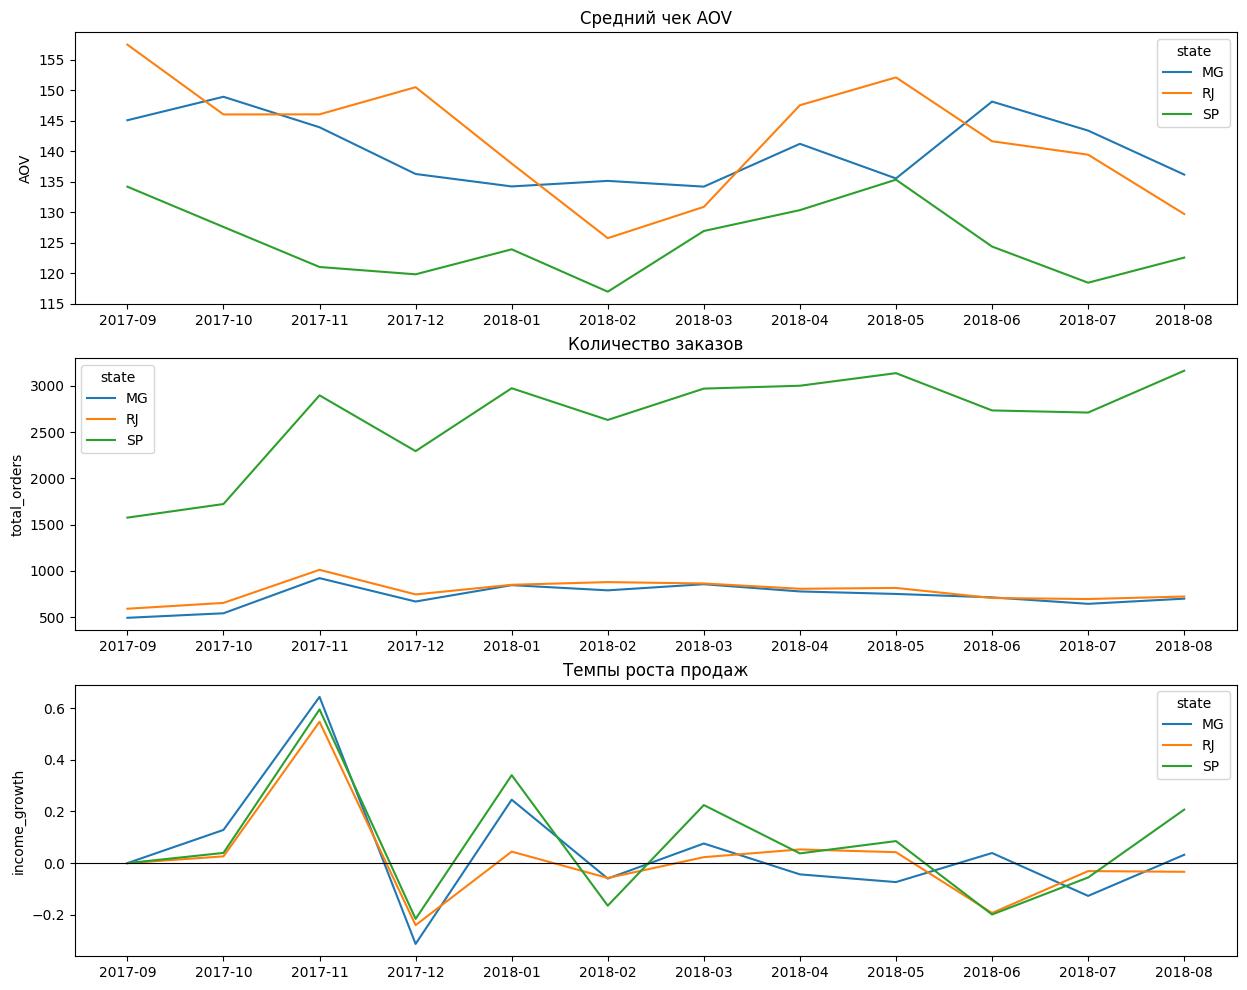

In [39]:
fig, axs = plt.subplots(3,1, figsize=(15,12))
sns.lineplot(data=states,
             x='month',
             y='AOV',
             hue='state',
             ax=axs[0])
axs[0].set_title('Средний чек AOV')
sns.lineplot(data=states,
             x='month',
             y='total_orders',
             hue='state',
             ax=axs[1])
axs[1].set_title('Количество заказов')
sns.lineplot(data=states,
             x='month',
             y='income_growth',
             hue='state',
             ax=axs[2])
axs[2].axhline(y=0, color='black', linewidth=0.8)
axs[2].set_title('Темпы роста продаж')
for i in range(3):
    axs[i].set_xlabel('')# чтобы не перекрывало название графика

Сан-Паулу явялется топ 1 штатом по количеству продаж, но стабильно уступает по среднему чеку Минас-Жейрос и Рио-Де-Жанейро. 

С учетом большой разницы в объеме заказов и тенденции росту количества заказов в Сан-Паулу, **рост среднего чека без падения количества заказов в Сан-Паулу значительно увеличит выручку**

Темпы роста продаж в целом схожи с общей картиной. Примечательно в Минас-Жейрас с 2018-05 к 2018-06 выручка выросла, когда в двух других штатах и в целом по Бразилии она снизилась

## 4. Анализ продаж по категориям

In [40]:
df_category = pd.read_sql("""
    WITH CTE AS (
        SELECT p.product_id,
            pt.product_category_name_english as category
        FROM product_category_name_translation pt
        JOIN products p ON pt.product_category_name = p.product_category_name
                          )
            SELECT strftime('%Y-%m', o.order_purchase_timestamp) as month,
                   CTE.category,
                   SUM(oi.price) as total_income,
                   COUNT(oi.order_id) as total_orders
            FROM order_items oi
            JOIN CTE ON oi.product_id = CTE.product_id
            JOIN orders o ON oi.order_id = o.order_id
            WHERE (o.order_purchase_timestamp BETWEEN '2017-09-01 00:00:00' AND '2018-09-31 23:59:59')
            AND (o.order_status = 'delivered') AND (o.order_delivered_customer_date IS NOT NULL)
            GROUP BY month, CTE.category
""", con)
df_category.head(3)

,month,category,total_income,total_orders
0,2017-09,agro_industry_and_commerce,1993.99,4
1,2017-09,air_conditioning,1629.15,7
2,2017-09,art,388.54,3


In [41]:
df_category.isna().sum()

month           0
category        0
total_income    0
total_orders    0
dtype: int64

### 4.1. abc анализ

In [42]:
data = df_category.groupby('category').agg(
    income = ('total_income','sum')
)

data.sort_values(by='income', ascending=False,inplace=True)
data['income_pct'] = data['income']/data['income'].sum()*100 #доля от всей выручки
data['cum_pct'] = data.income_pct.cumsum()

data.head(3)

,income,income_pct,cum_pct
category,,,
health_beauty,986035.80,9.801737,9.801737
watches_gifts,962050.05,9.563306,19.365043
bed_bath_table,768510.95,7.639421,27.004463


In [43]:
def abc_classify(value):
    if value <= 80:
        return 'a'
    elif value <= 95:
        return 'b'
    else:
        return 'c'

data['abc'] = data.cum_pct.apply(abc_classify)

categories_abc_xyz = pd.DataFrame(data['abc'])

In [44]:
data['abc'].value_counts()

abc
c    39
a    16
b    16
Name: count, dtype: int64

### 4.2. xyz анализ

In [45]:
data = df_category.groupby('category').agg(
    mean_demand = ('total_orders', 'mean'),
    std_demand = ('total_orders', 'std')
)
data['cv'] = data['std_demand']/data['mean_demand']*100

<Axes: ylabel='cv'>

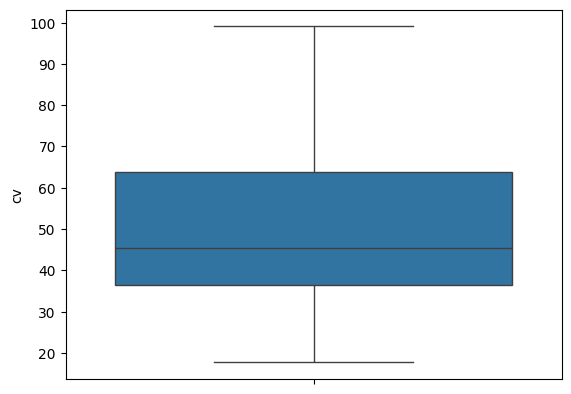

In [46]:
sns.boxplot(data['cv'])

In [47]:
data

,mean_demand,std_demand,cv
category,,,
agro_industry_and_commerce,15.333333,8.194603,53.443062
air_conditioning,16.333333,7.401883,45.317654
art,14.583333,11.325421,77.660027
arts_and_craftmanship,5.500000,5.259911,95.634751
audio,24.083333,8.005207,33.239612
...,...,...,...
stationery,173.583333,79.608655,45.861923
tablets_printing_image,3.800000,3.765339,99.087868
telephony,278.416667,64.730853,23.249633


In [ ]:
def xyz_classify(value):
    if value <= 20: #при классической классификации через 10 и 25 в класс X не приcваивается ни одной категории
        return 'x'
    elif value <= 40:
        return 'y'
    else:
        return 'z'
    
data['xyz'] = data['cv'].apply(xyz_classify)

categories_abc_xyz['xyz'] = data['xyz']
categories_abc_xyz['abc_xyz'] = categories_abc_xyz['abc']+categories_abc_xyz['xyz']
categories_abc_xyz.sample(3)

,abc,xyz,abc_xyz
category,,,
baby,a,x,ax
fashion_childrens_clothes,c,y,cy
furniture_decor,a,y,ay


In [49]:
data = df_category.merge(categories_abc_xyz, how='left', left_on='category', right_index=True)

Text(0.5, 1.0, 'Выручка по классам категорий')

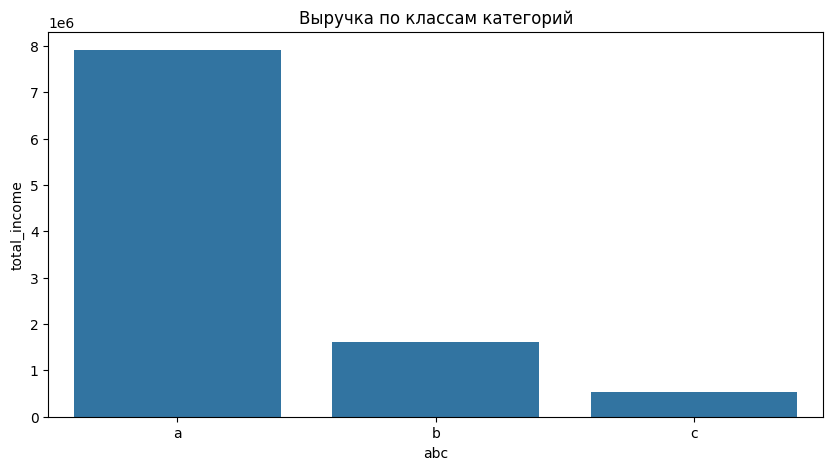

In [50]:
abc_agg = data.groupby('abc').agg(total_income = ('total_income','sum'))
plt.figure(figsize=(10,5))
sns.barplot(data=abc_agg, x='abc', y='total_income')
plt.title('Выручка по классам категорий')

Text(0.5, 1.0, 'Динамика спроса по классам категорий')

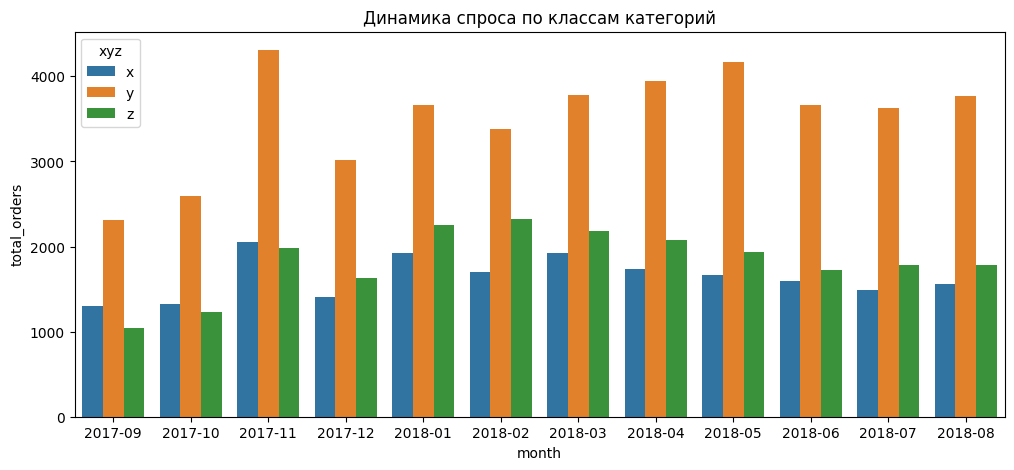

In [51]:
xyz_demand = data.groupby(['xyz','month']).agg(total_orders = ('total_orders','sum')).reset_index()
plt.figure(figsize=(12,5))
sns.barplot(xyz_demand, x='month', y='total_orders', hue='xyz')
plt.title('Динамика спроса по классам категорий')

In [52]:
categories_abc_xyz.abc_xyz.value_counts()

abc_xyz
cz    31
bz    10
ay     8
cy     8
by     6
az     4
ax     4
Name: count, dtype: int64

In [53]:
con.close()

# Выводы

1. Были **выявлены сезонные колебания продаж** в конце 2017 года с последующим ростом.  
В ноябре 2017 продажи выросли на 52% в сравнении с предыдущим месяцем (скорее всего результат ноябрьских скидок). К концу периода **выручка увеличилась на 231177 реалов в сравнении с началом (38%)**.  
  
  2. **Выявлена статистически значимая связь способа оплаты и стоимости оплаты**  
Наиболее крупные платежи совершаются с помощью кредитной карты: 107.78 реалов в медиане  
Средняя стоимость у болето и дебетовой карты: 94.77 - 92.57 реалов в медиане    
Наименьшие тразакции производятся с помощью ваучеров: 42.77 реалов в медиане  

  Наиболее популярный способ оплаты - кредитная карта (74.7%). Далее идут boleto (18.7%), ваучер(4.9%) и дебетовая карта(1.7%), % от общего количества транзакций. Значительные изменения заметны для дебетовой карты: доля от общего числа транзакций с 2018-03 по 2018-08 увеличилась в 4 раза, средняя стоимость транзакции увеличилась на 66 валютных единиц.
      
  3. Штат Сан-Паулу потенциально может стать точкой роста продаж: средний чек находится на уровне ниже топ 2 и топ 3 штатов при значительно большем количестве заказов, **рост среднего чека без падения количества заказов в Сан-Паулу значительно увеличит выручку**

  4. Проведен ABC-XYZ анализ по категориям товаров. **71 категория классифицирована** по вкладу в общую прибыль и стабильности спроса.

* В ходе анализа выявлено 7 "подозрительных" заказов в базе, имеющих статус доставлен, но не имеющих дату доставки.

In [54]:
sus_orders

2235     2d1e2d5bf4dc7227b3bfebb81328c15f
15389    f5dd62b788049ad9fc0526e3ad11a097
32756    2ebdfc4f15f23b91474edf87475f108e
59212    e69f75a717d64fc5ecdfae42b2e8e086
61891    0d3268bad9b086af767785e3f0fc0133
72859    ab7c89dc1bf4a1ead9d6ec1ec8968a84
73151    20edc82cf5400ce95e1afacc25798b31
Name: order_id, dtype: object